In [1]:
import sys, os, importlib
import rasterio
from rasterio.plot import show
import numpy as np

import geopandas as gpd
import pandas as pd

from shapely.geometry import box
from osgeo import gdal
from rasterstats import zonal_stats


from matplotlib import pyplot
import matplotlib.colors as colors

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append("/home/public/Code/GOST")

import GOSTRocks.rasterMisc as rMisc
import GOSTRocks.Urban.UrbanRaster as urban

Pop could be extracted directly from the zip file, but we can't save to public/Data. So it would have to be extracted to personal files. Maybe there is a workaround

In [3]:
iso3 = "VCT"

#unzip and extract
# pop_path = "/home/public/Data/GLOBAL/Population/WorldPop_PPP_2020"
# pop_layer_zip = os.path.join(pop_path, "global_mosaic_ppp_100m_2020_vrt.zip")
# with zipfile.ZipFile(pop_layer_zip, 'r') as zip_ref:
#     zip_ref.extract(f"MOSAIC_ppp_prj_2020/ppp_prj_2020_{iso3}.tif", path = pop_path)
# pop_layer_file = os.path.join(pop_path, "MOSAIC_ppp_prj_2020/ppp_prj_2020_%s.tif" % iso3)

pop_layer_file =   "/home/public/Data/GLOBAL/Population/WorldPop_PPP_2020/ppp_prj_2020_%s.tif" % iso3
# flood_layer_file = "/home/public/Data/GLOBAL/FLOOD_SSBN/v1_2016/saint_vincent_grenadines/VC_pluvial_undefended/VC-PU-1000-1.tif"
wsf_layer_file =   "/home/public/Data/GLOBAL/WSF/SaintVincentAndTheGrenadines_WSF_evolution.tif"

flood_path = "/home/public/Data/GLOBAL/FLOOD_SSBN/v1_2016/saint_vincent_grenadines"
periods = ['5-1', '100-1', '1000-1']
flood_types = ['fluvial', 'pluvial']
iso2 = "VC"

flood_files = []
for period in periods:
    fluvial = os.path.join(flood_path, f"{iso2}_fluvial_undefended", f"{iso2}-FU-{period}.tif")
    pluvial = os.path.join(flood_path, f"{iso2}_pluvial_undefended", f"{iso2}-PU-{period}.tif")
    flood_files.append(fluvial)
    flood_files.append(pluvial)

out_folder = "/home/wb514197/data/Country/%s/INFRA" % iso3
if not os.path.exists(out_folder):
    os.makedirs(out_folder)

In [4]:
# Generate extents layer for rasters
pop_layer = rasterio.open(pop_layer_file)
flood_layer = rasterio.open(flood_layer_file)
wsf_layer = rasterio.open(wsf_layer_file)

wsf_bounds = box(*wsf_layer.bounds)
flood_bounds = box(*flood_layer.bounds)
pop_bounds = box(*pop_layer.bounds)

data = [["WSF",wsf_bounds],
       ["FLOOD",flood_bounds],
       ["POP",pop_bounds]]
all_extents = pd.DataFrame(data,columns=["TYPE","geometry"])
all_extents.to_csv(os.path.join(out_folder, "file_extents.csv"))

In [4]:
input_files = flood_files+[pop_layer_file, wsf_layer_file]

In [5]:
input_files

['/home/public/Data/GLOBAL/FLOOD_SSBN/v1_2016/saint_vincent_grenadines/VC_fluvial_undefended/VC-FU-5-1.tif',
 '/home/public/Data/GLOBAL/FLOOD_SSBN/v1_2016/saint_vincent_grenadines/VC_pluvial_undefended/VC-PU-5-1.tif',
 '/home/public/Data/GLOBAL/FLOOD_SSBN/v1_2016/saint_vincent_grenadines/VC_fluvial_undefended/VC-FU-100-1.tif',
 '/home/public/Data/GLOBAL/FLOOD_SSBN/v1_2016/saint_vincent_grenadines/VC_pluvial_undefended/VC-PU-100-1.tif',
 '/home/public/Data/GLOBAL/FLOOD_SSBN/v1_2016/saint_vincent_grenadines/VC_fluvial_undefended/VC-FU-1000-1.tif',
 '/home/public/Data/GLOBAL/FLOOD_SSBN/v1_2016/saint_vincent_grenadines/VC_pluvial_undefended/VC-PU-1000-1.tif',
 '/home/public/Data/GLOBAL/Population/WorldPop_PPP_2020/ppp_prj_2020_VCT.tif',
 '/home/public/Data/GLOBAL/WSF/SaintVincentAndTheGrenadines_WSF_evolution.tif']

Would be useful to have a dict of with file information mapped to the band index, for now...

In [6]:
file_names = [path.split("/")[-1] for path in input_files]
file_names

['VC-FU-5-1.tif',
 'VC-PU-5-1.tif',
 'VC-FU-100-1.tif',
 'VC-PU-100-1.tif',
 'VC-FU-1000-1.tif',
 'VC-PU-1000-1.tif',
 'ppp_prj_2020_VCT.tif',
 'SaintVincentAndTheGrenadines_WSF_evolution.tif']

In [87]:
# Generate stacked Tif from input bands
out_vrt = os.path.join(out_folder, "combo.vrt")
out_tif = out_vrt.replace(".vrt", ".tif")
outds = gdal.BuildVRT(out_vrt, input_files, separate=True)
outds = gdal.Translate(out_tif, outds)

### 2. Flood Maps

In [242]:
out_tif = os.path.join(out_folder, "combo.tif")

In [243]:
cur_tif = rasterio.open(out_tif)
fluvial_1_in_1000 = cur_tif.read(5)
pluvial_1_in_1000 = cur_tif.read(6)

In [244]:
fluvial_1_in_1000[(fluvial_1_in_1000 < 0) | (fluvial_1_in_1000 == 999)] = np.NaN
pluvial_1_in_1000[(pluvial_1_in_1000 < 0) | (pluvial_1_in_1000 == 999)] = np.NaN

In [245]:
np.nanmax(fluvial_1_in_1000)

0.0

In this country there is no data in the fluvial file, otherwise we should take the max depth

In [246]:
np.nanmax(pluvial_1_in_1000)

10.0

In [247]:
# pluvial_1_in_1000 = np.ma.array(pluvial_1_in_1000, mask=np.isnan(pluvial_1_in_1000))

(array([52019.,  2652.,  1240.,   815.,   373.,   181.]),
 array([ 0.  ,  0.1 ,  0.25,  0.5 ,  1.  ,  2.  , 10.  ]),
 <a list of 6 Patch objects>)

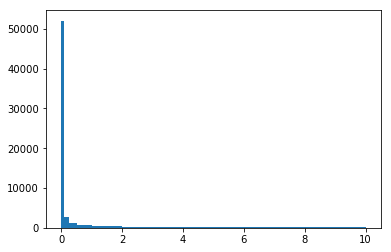

In [248]:
pyplot.hist(pluvial_1_in_1000[~np.isnan(pluvial_1_in_1000)], bins=[0,0.1,0.25,0.5,1,2,10])

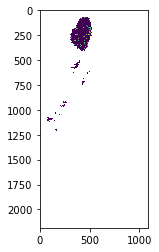

In [249]:
show(pluvial_1_in_1000, norm=colors.PowerNorm(gamma=0.1))

In [250]:
# first bin includes all zeros, the last bin captures all np.NaN (water bodies)
# [1e-10 - 0.5) : 2
# [0.5 - 1) : 3
# [1 - 2) : 4
# [2 - 11): 5

flood_bins = [0, 1e-10, 0.5, 1, 2, 11]
flood_cat = np.digitize(pluvial_1_in_1000, flood_bins)-1

In [265]:
len(flood_cat[flood_cat==0]) == len(pluvial_1_in_1000[pluvial_1_in_1000==0])

True

In [266]:
len(flood_cat[flood_cat==5]) == len(pluvial_1_in_1000[np.isnan(pluvial_1_in_1000)])

True

In [267]:
# reclassify 0 (depth 0) to 5 (no data)
# our boolean flood rasters will be inlcusive of lower depths (up to x meters flooded)
flood_cat[flood_cat==0] = 5

In [253]:
zs_cat = pd.DataFrame(zonal_stats(urban_extents, flood_cat, affine=dst_transform, categorical=True))

In [254]:
zs_cat

,0.0,1.0,2.0,3.0,4.0,5.0
0,8870,1056.0,273.0,129.0,29.0,360
1,965,2.0,NaN,NaN,NaN,67
2,329,208.0,26.0,3.0,NaN,14
3,350,41.0,9.0,5.0,NaN,50
4,423,NaN,NaN,NaN,NaN,96


In [21]:
# flood_cat_masked = np.ma.array(flood_cat, mask=nodata)

In [268]:
# boolean flood rasters can be inlcusive of lower depths (up to x meters flooded)

non_flooded = (flood_cat == 5)*1        # not flooded, either depth 0, water, or "no data"
flood_very_high = (flood_cat <= 4)*1    # up to 10 meters flooded
flood_high = (flood_cat <= 3)*1         # up to 2 meters flooded
flood_medium = (flood_cat <= 2)*1       # up to 1 meters flooded
flood_low = (flood_cat == 1)*1          # up to 0.5 meters flooded

In [269]:
# water_body = (flood_cat == 5)*1         # "no data", ocean or permanent water body
# flood_very_high = (flood_cat == 4)*1    # 2 to 10 meters flooded
# flood_high = (flood_cat == 3)*1         # 1 to 2 meters flooded
# flood_medium = (flood_cat == 2)*1       # 0.5 to 1 meters flooded
# flood_low = (flood_cat == 1)*1          # 0 to 0.5 meters flooded
# no_flood = (flood_cat == 0)*1           # not flooded, depth 0

Alternatively, we can leave this in categorical format and aggregate later?

In [270]:
flood_very_high.sum()

5261

In [271]:
flood_high.sum()

5080

In [272]:
flood_medium.sum()

4707

In [273]:
flood_low.sum()

3892